# Importing Necessary Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.sparse import csr_matrix
import os

from utils import preprocessing

# Preprocessing

### 1 - Creating an AnnData Object
An AnnData object is a data structure store high-dimensional annotated data along with metadata and additional information for analysis.

The structure of an AnnData object consists of the main matrix, annotations (obs and var), unstructured metadata, layers, Obsm and Varm, Obsp and Varp. However, here only the main matrix and the annotations will be necessary.

- Main Matrix - It's a 2D array in which the rows represent observations (ex: cells) and the columns represent variables (ex: genes). The values in this case, represent gene expression counts.
- The obs (adata.obs) is a dataframe-like structure with annotations for the observations. Each row corresponds to a cell, and columns store metadata (e.g., cell type, batch, condition).
- The var (adata.var) is another dataframe-like structure with annotations for the variables. Each row corresponds to a gene, and columns store metadata (e.g., gene name, biotype, feature type).

### 2 - Removing Doublets
Doublets are artifacts in single-cell RNA sequencing experiments where two or more cells are captured together and sequenced as a single unit. This results in mixed gene expression profiles that do not represent any true biological cell type. Doublets can arise due to high cell loading densities, cell aggregation, or technical issues during sample preparation. Although removing doublets is not a strictly necessary step, detecting and filtering doublets is important for ensuring the accuracy and reliability of single-cell RNA-seq data analysis. Doublets should be removed in individual samples and not in integrated samples.

Doublets can be removed using SOLO (scvi), which identifies cells with mixed gene expression profiles indicative of doublets. After detection, predicted doublets can be filtered from the dataset. Thus, we can train a model to predict whether a cell is a doublet or not and later remove the doublets. **Check the 'preprocessing' module in the 'utils' directory for more details.**

### 3 - Label Mitochondrial Genes
Labeling mitochondrial genes is important for quality control and data interpretation. For example, high mitochondrial gene expression often indicates stressed, damaged, or dying cells. A common threshold to filter out low quality cells is 10% mitochondrial RNA.

### 4 - Label Ribosomal Genes
Ribosomal genes are also labeled for quality control and interpretation. High ribosomal RNA content may indicate poor-quality cells or technical artifacts, as ribosomal transcripts can dominate the RNA pool. While not always filtered out, ribosomal genes are often labeled and monitored to avoid misleading interpretations.

### 5 - Quality Control
Quality control (QC) ensures that the data accurately represents biological differences rather than technical artifacts. Without proper QC, low-quality cells, dead cells, or technical noise can bias downstream analyses, leading to misleading clustering, incorrect differential expression results, and poor biological interpretations.

### 6 - Normalization
Normalization is very important because raw gene expression data can be biased by various technical and biological factors.
Without proper normalization, downstream analyses like clustering, differential expression, and trajectory inference can be misleading. Normalizing the data allows an unbiased comparison between cells.

In [2]:
separated_adata = []
for file in os.listdir('raw_data/samples/'):
    raw_adata = preprocessing.create_adata(f'raw_data/samples/{file}')
    filtered_adata = preprocessing.filter_genes(raw_adata, 10, 2000)
    doub_adata = preprocessing.identify_doublets(filtered_adata, 0.8)
    no_doub_adata = preprocessing.remove_doublets(raw_adata, doub_adata)
    no_doub_adata = preprocessing.label_mito(no_doub_adata)
    no_doub_adata = preprocessing.label_ribo(no_doub_adata, 'raw_data/human_ribo_genes.grp')
    clean_adata = preprocessing.quality_control(no_doub_adata, 200, 0.98, 10, 30)

    separated_adata.append(clean_adata)
    print(f'{len(separated_adata)}/{len(os.listdir('raw_data/samples/'))} samples processed.')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.289. Signaling Trainer to stop.
1/2 samples processed.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.233. Signaling Trainer to stop.
2/2 samples processed.


In [5]:
# Merging all adata objects.
raw_merged_adata = sc.concat(separated_adata)

# Filtering genes in the AnnData object by retaining only those genes that are expressed in at least 10 cells.
sc.pp.filter_genes(raw_merged_adata, min_cells = 10)

In [6]:
# Saving the preprocessed and merged AnnData object to a h5ad file.
raw_merged_adata.write_h5ad('output_files/raw_merged_preprocessed_data.h5ad')

In [7]:
raw_merged_adata = sc.read_h5ad('output_files/raw_merged_preprocessed_data.h5ad')

In [8]:
# Creating a new layer in the AnnData object to preserve the original raw counts so they can be accessed later, even after normalization.
raw_merged_adata.layers['raw_counts'] = raw_merged_adata.X.copy()

In [9]:
# Normalizing the data.
raw_merged_adata = preprocessing.normalization(raw_merged_adata)

In [10]:
# The number of cells should less than half of the genes.
cell_gene_ratio = 0.4
if raw_merged_adata.shape[1]/raw_merged_adata.shape[0] > cell_gene_ratio:
    sc.pp.highly_variable_genes(raw_merged_adata, 
                                n_top_genes=raw_merged_adata.shape[0]*cell_gene_ratio, 
                                subset = True, 
                                layer = 'raw_counts', 
                                flavor = "seurat_v3", 
                                batch_key="Sample")

In [11]:
# Changing index names.
raw_merged_adata.obs.index = [a[:-4] for a in raw_merged_adata.obs.index]

In [12]:
# Saving the normalized AnnData object to a h5ad file.
raw_merged_adata.write_h5ad('output_files/norm_merged_preprocessed_data.h5ad')

# Checking the Data

In [15]:
prepro_adata = sc.read_h5ad('output_files/norm_merged_preprocessed_data.h5ad')

In [16]:
print(f'There are {prepro_adata.shape[0]} cells and {prepro_adata.shape[1]} genes in this AnnData object')

There are 110910 cells and 29542 genes in this AnnData object


In [17]:
prepro_adata

AnnData object with n_obs × n_vars = 110910 × 29542
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'raw_counts'

In [18]:
prepro_adata.obs.head()

Sample  doublet  n_genes_by_counts  total_counts  \
GGACGTCCACTGAATC  L01cov    False               2089        4558.0   
AGATCGTTCTAGGCCG  L01cov    False               2022        4540.0   
CCCTCAACATCCGATA  L01cov    False               2147        4498.0   
CCGGGTACAACGTATC  L01cov    False               2141        4270.0   
TTGTTCATCTACGCAA  L01cov    False               2185        4439.0   

                  total_counts_mito  pct_counts_mito  total_counts_ribo  \
GGACGTCCACTGAATC              241.0         5.287406                7.0   
AGATCGTTCTAGGCCG              296.0         6.519824                6.0   
CCCTCAACATCCGATA                0.0         0.000000               25.0   
CCGGGTACAACGTATC               51.0         1.194379                7.0   
TTGTTCATCTACGCAA              321.0         7.231359               10.0   

                  pct_counts_ribo  n_genes  
GGACGTCCACTGAATC         0.153576     2089  
AGATCGTTCTAGGCCG         0.132159     2022  
CCCTCAACATCCGATA         0.555803     2147  
CCGGGTACAACGTATC         0.163934     2141  
TTGTTCATCTACGCAA         0.225276     2185

In [19]:
prepro_adata.var.head()

n_cells
AL627309.1      142
AL627309.5      408
AL627309.4       26
AL669831.2       11
LINC01409      2478

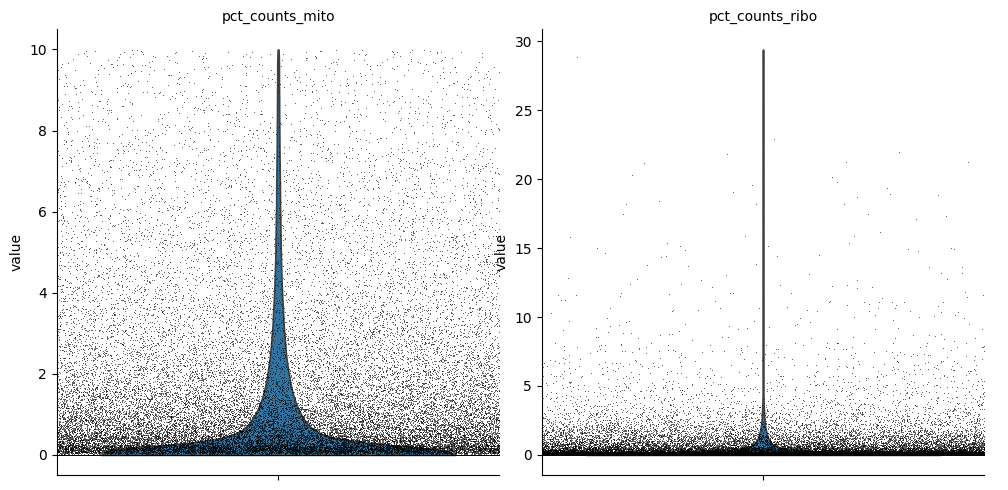

In [20]:
# Checking mito counts and ribo counts qc metrics for outliers.
sc.pl.violin(prepro_adata, ['pct_counts_mito', 'pct_counts_ribo'], 
             jitter=1, size=0.5, multi_panel=True)

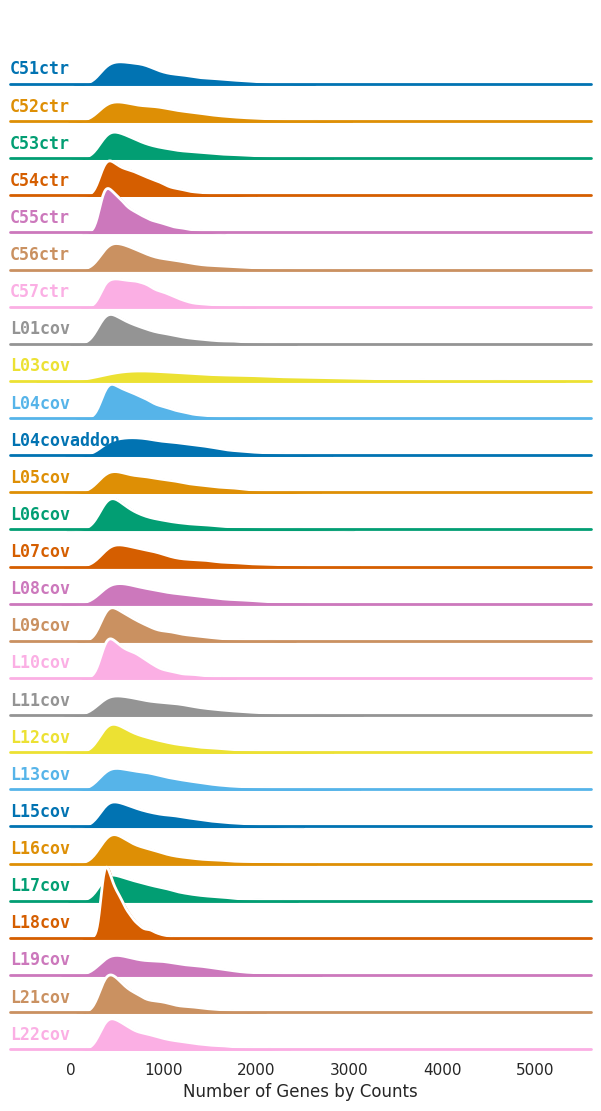

In [21]:
# Checking the numer of genes by count of each sample.

def labeler(x, color, label):
    ax = plt.gca()
    ax.text(x=0, y=.2, s=label, fontname='monospace', fontweight='semibold', color=color,
            ha='left', va='center', transform=ax.transAxes)

metric = 'n_genes_by_counts'
sns.set(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

grid = sns.FacetGrid(data=prepro_adata.obs, row='Sample', hue='Sample', aspect=15, height=0.5, palette='colorblind')
grid.map(sns.kdeplot, metric, clip_on=False, fill=True, alpha=1, linewidth=1.5)
grid.map(sns.kdeplot, metric, clip_on=False, color='w', lw=2)
grid.map(plt.axhline, y=0, lw=2, clip_on=False)
grid.map(labeler, metric)
grid.figure.subplots_adjust(hspace=-0.5)
grid.set_titles('')
grid.set(yticks=[], ylabel='', xlabel='Number of Genes by Counts')
grid.despine(bottom=True, left=True)

plt.show()

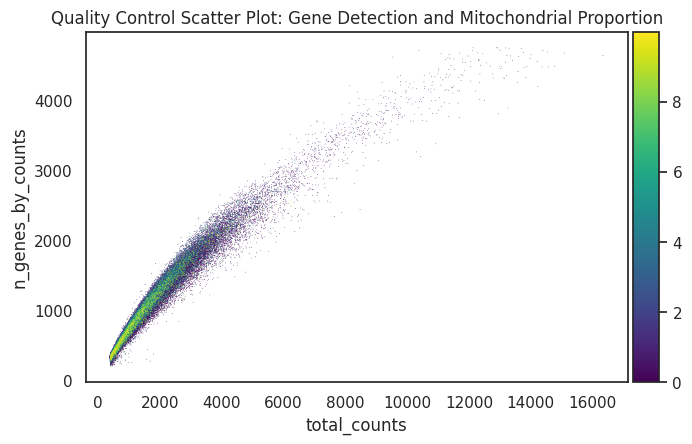

In [22]:
sc.pl.scatter(prepro_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mito', color_map='viridis', 
              title='Quality Control Scatter Plot: Gene Detection and Mitochondrial Proportion')

# Integration
The objective of the integration step is to integrate data from different sources (like multiple batches, samples, or experiments) and remove technical artifacts (systematic, non-biological variation introduced during the experimental or computational processing of the data.), such as batch effects, while preserving the true biological variation.

### 1 - Setting up the AnnData object for SCVI
Before using SCVI, the data needs to be prepared. Incorporating both categorical (e.g., batch) and continuous (e.g., sequencing depth, mitochondrial content) covariates, SCVI specifically learns to correct for these technical variations.

### 2 - Initializing and Training the SCVI Model and Storing the Latent Representation
An instance of the SCVI model using the prepared AnnData object is created and trained.
During training, the VAE learns a compressed, latent representation of the single-cell data, capturing both biological signal and technical variation. A latent representation is a lower-dimensional (dimensional reduction), abstract encoding of high-dimensional data that captures its most important features while filtering out noise and irrelevant variation. In this context, the latent representation is a compressed, biologically meaningful space where similar cells are positioned closer together based on their underlying gene expression patterns. 

Here, SCVI takes the scRNA-seq data and maps each cell to a latent space. This mapping is probabilistic, meaning each cell’s latent representation is modeled as a distribution, not a fixed point (This accounts for uncertainty in the data). Therefore, the learned latent space captures true biological variation while removing unwanted noise. Meaning that cells with similar gene expression profiles (even across different batches) are grouped together.

After obtaining the latent representation, it is stored in the ```.obsm``` attribute of the AnnData object.

### 3 - Obtaining Normalized Expression Values
Normalization of expression data to a constant library size (10<sup>4</sup> in this case), to make expression levels comparable between cells. The normalized data is stored in a new layer of the AnnData object.

### 4 - Building the Nearest Neighbor Graph
The SCVI latent space is used to determine cell-to-cell similarities, which are captured in a neighbor graph based on the latent representations. The neighbor graph's structure is stored in the AnnData object in ```.obsp.distances``` and ```.obsp.connectivities.``` This neighbor graph represents and encodes connectivity among cells, enabling clustering, trajectory inference, and visualization. This connectivity refers to how cells are linked in the graph based on their similarity in gene expression.

### 5 - Generating a UMAP
UMAP (Uniform Manifold Approximation and Projection) is a non-linear dimensionality reduction technique that helps visualize complex, high-dimensional data in a low-dimensional space.

### 6 - Clustering with the Leiden Algorithm and Visualization using UMAP
The previously built neighbor graph is used to perform community detection (clustering). Clustering algorithms like Leiden identify groups of similar cells (cell types or states) based on their connectivity. The Leiden algorithm identifies clusters of cells based on their gene expression profiles.

In [24]:
# Preparing the AnnData object for use with scVI.
scvi.model.SCVI.setup_anndata(prepro_adata, layer = "raw_counts",
                              categorical_covariate_keys=["Sample"],
                              continuous_covariate_keys=['pct_counts_mito', 'total_counts', 'pct_counts_ribo'])

In [25]:
# Initializing a Variational Autoencoder (VAE) model using the prepared data.
integration_vae_model = scvi.model.SCVI(prepro_adata)

In [26]:
# Training the VAE on the RNA-seq data.
integration_vae_model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [28]:
# Saving model.
integration_vae_model.save('output_files/integration_model')

In [37]:
# Loading model.
integration_vae_model = scvi.model.SCVI.load('output_files/integration_model', prepro_adata)

INFO     File output_files/integration_model/model.pt already downloaded                                           


In [38]:
# Storing the Latent Representation in .obsm.
prepro_adata.obsm['X_scVI'] = integration_vae_model.get_latent_representation()

In [39]:
# Normalizing the data and storing it in a new layer.
prepro_adata.layers['scvi_normalized'] = integration_vae_model.get_normalized_expression(library_size = 1e4)

In [40]:
# Getting the Nearest Neighbor Graph.
sc.pp.neighbors(prepro_adata, use_rep = 'X_scVI')

In [41]:
# Saving the integrated data.
prepro_adata.write_h5ad('output_files/integrated_data.h5ad')

In [42]:
adata = sc.read_h5ad('output_files/integrated_data.h5ad')

In [43]:
# Clustering with Leiden Algorithm (Resulution can be changed depending on the clusters. Higher resolution = More clusters.)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 1.7)

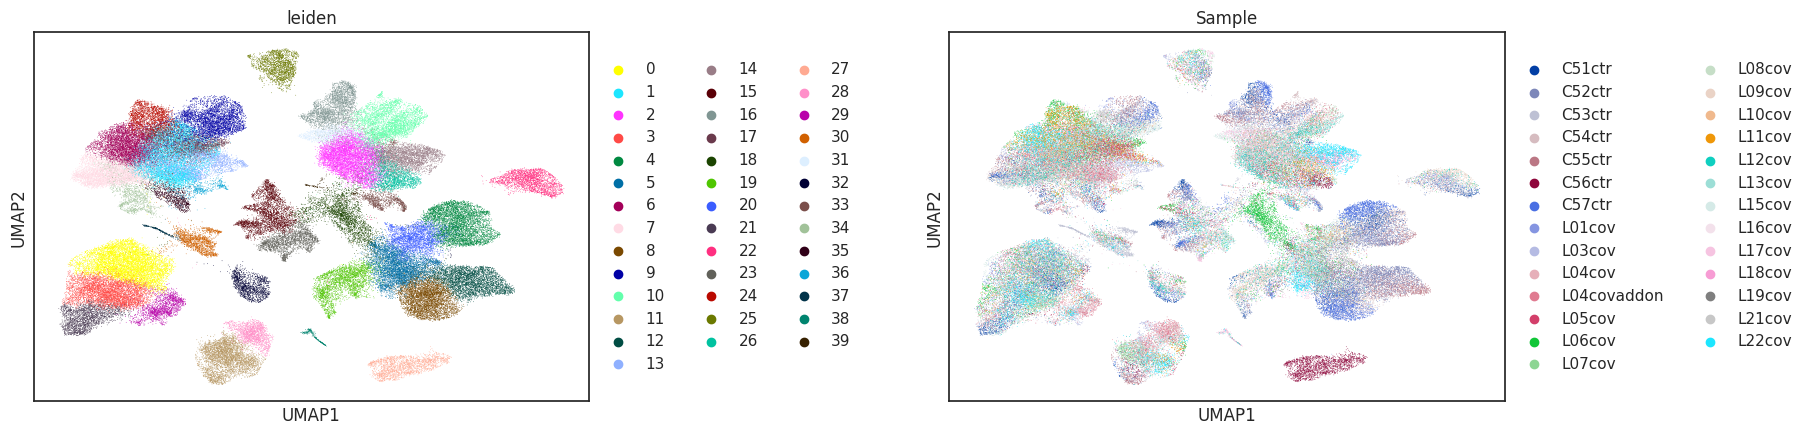

In [45]:
# Visualization of Leiden CLustering using UMAP.
sc.pl.umap(adata, color = ['leiden', 'Sample'], 
           frameon = True, 
           wspace=0.5, 
           ncols=2,)

# Cell Annotation
Cell annotation is the process of assigning biological labels or identities to individual cells based on their molecular characteristics (like gene expression).
The Leiden algorithm identifies clusters of cells based on their gene expression profiles. These clusters are cell populations that share similar transcriptomic features. Thus, clustering can help uncover unidentified cell types or subtypes within a dataset when cell type annotations are unavailable.

Cell annotation can be done manually after clustering by assigning cell type labels to clusters based on differentially expressed genes (markers) that are known to characterize specific cell types, as identified from literature or known gene expression profiles.
On the other hand, tools like or CellAssign can be used to automatically assign cell types based on the expression profiles and reference datasets.

To check the manual annotation please go [here](https://github.com/Fran-bot0/Cell_Annotation_Project).

In [7]:
# Ranking genes for each cluster and comparing them against all other clusters to identify markers expressed in certain clusters.
sc.tl.rank_genes_groups(adata, 'leiden')

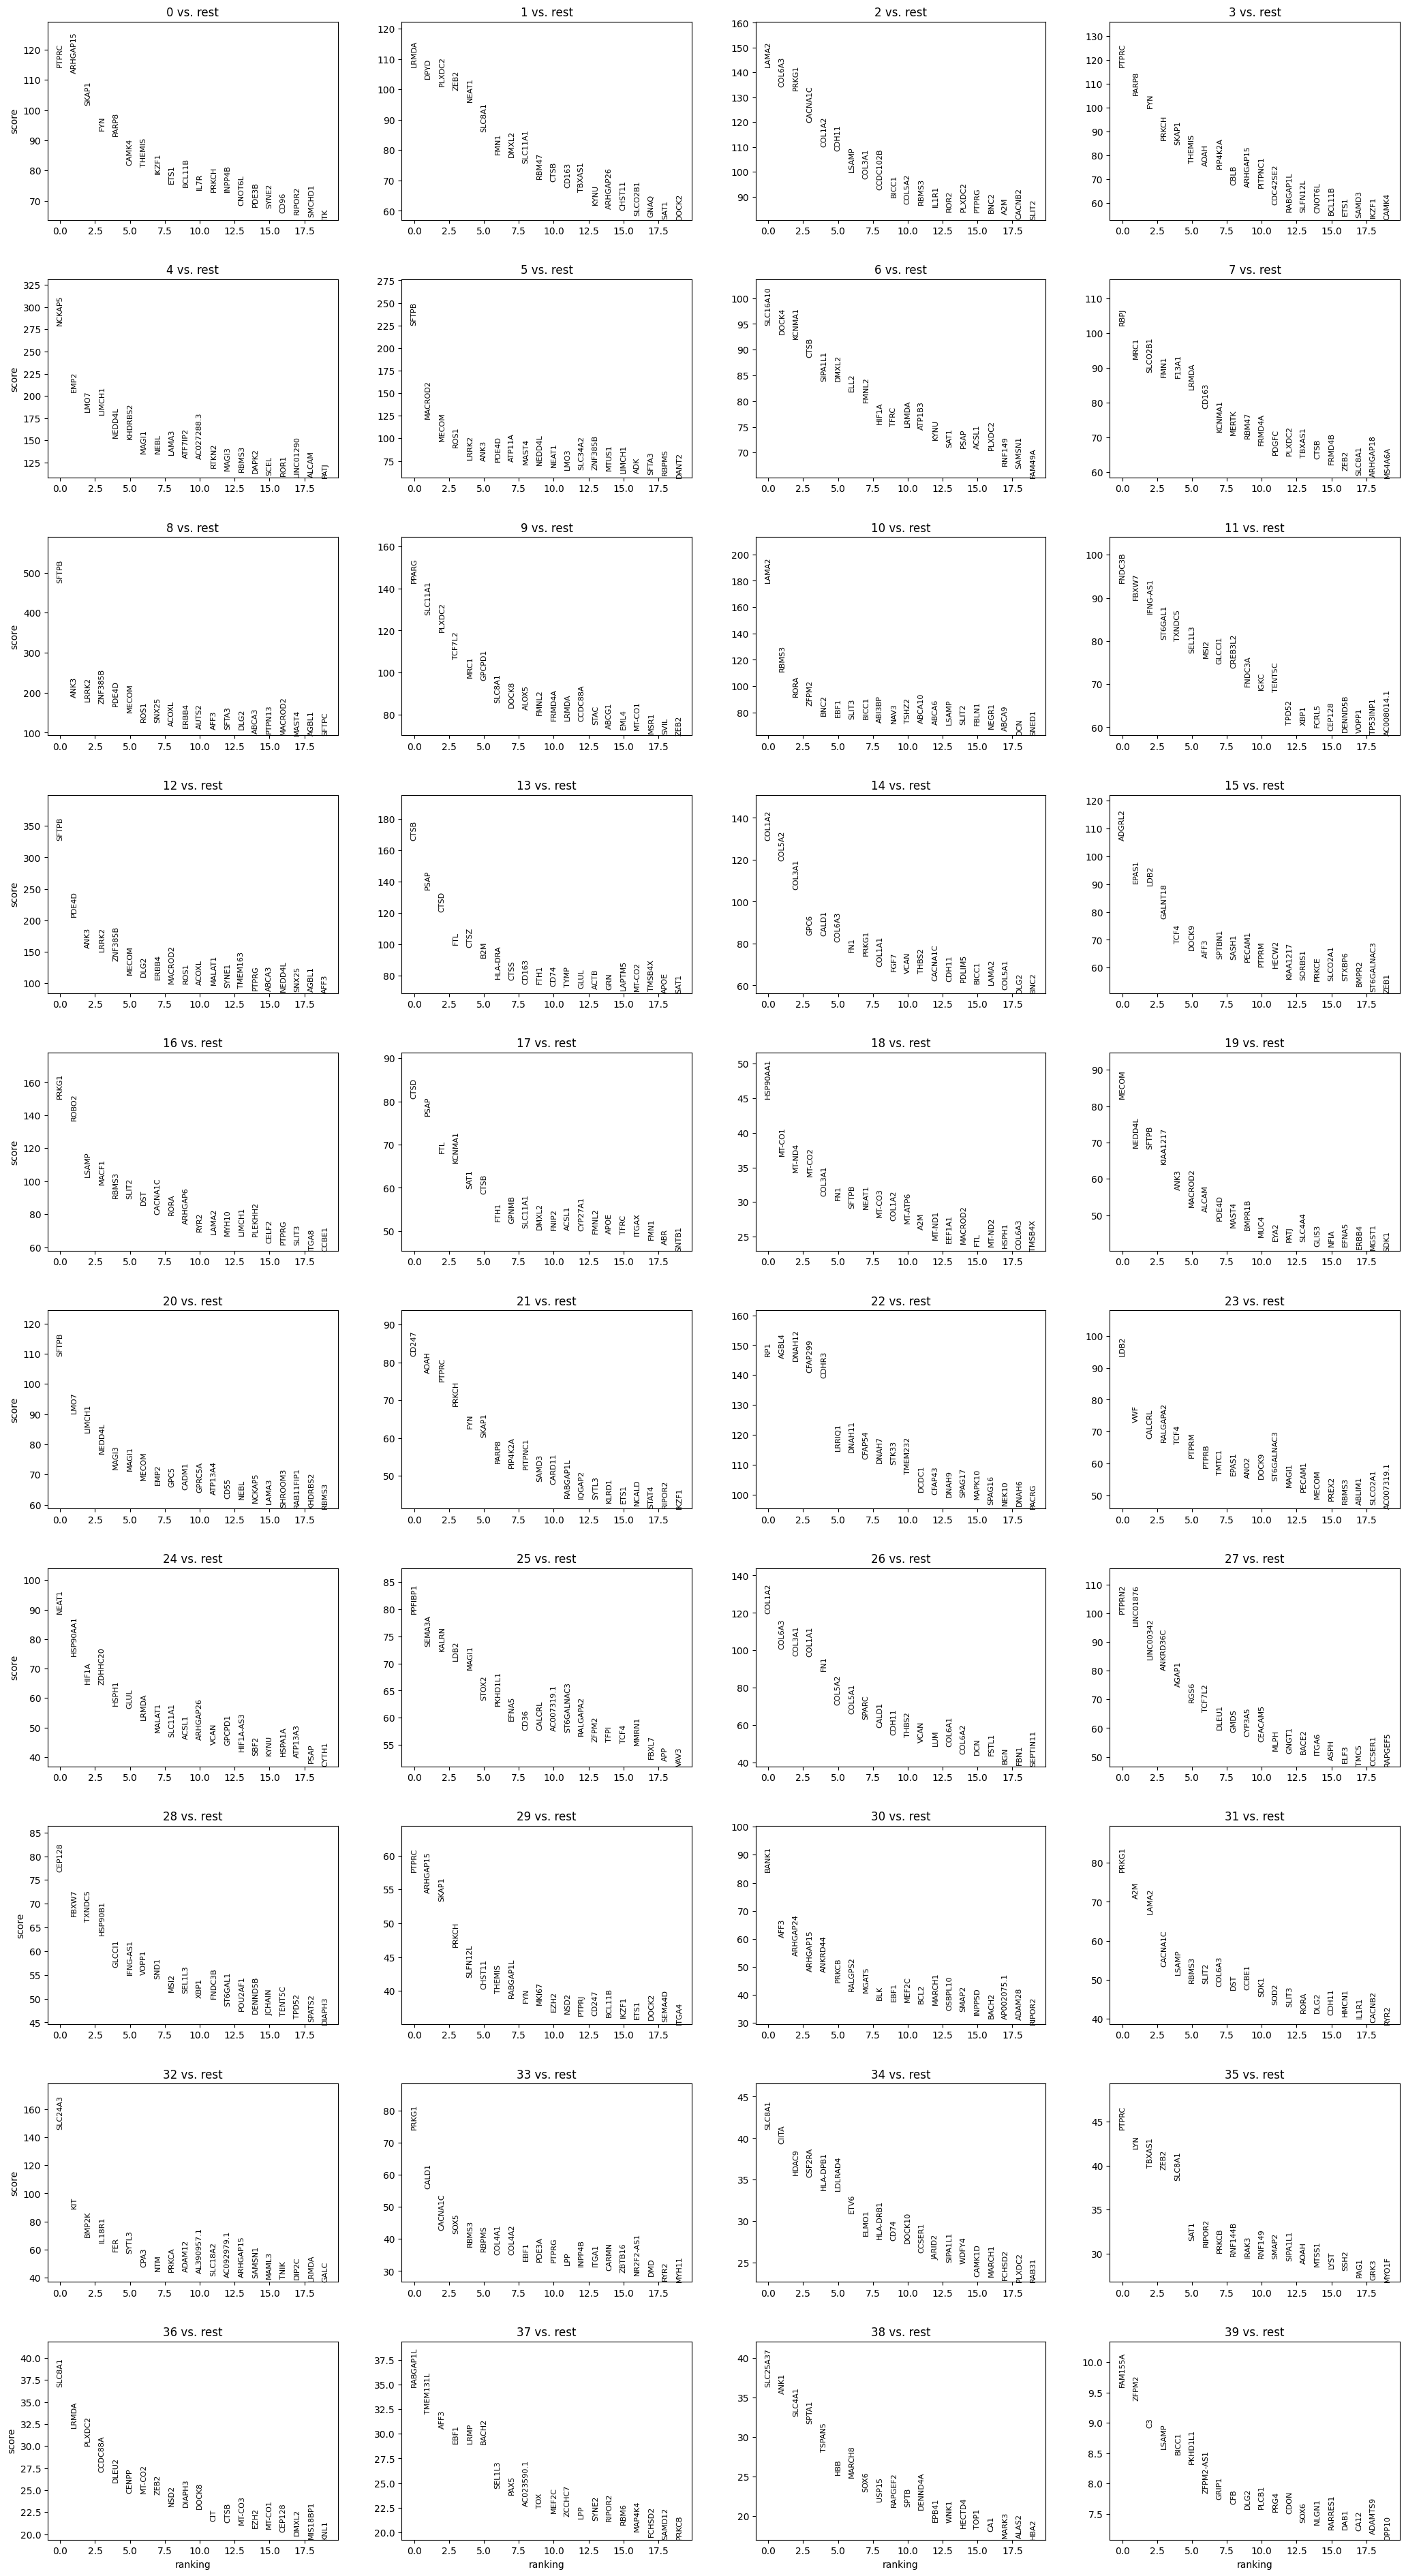

In [8]:
# Plot showing the top 20 ranked genes for each cluster.
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [ ]:
# Performing differential expression, comparing gene expression levels between the different clusters.
marker_genes = integration_vae_model.differential_expression(groupby = 'leiden')

DE...:   0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
# Filtering only statistically significantly expressed genes and with a log fold-change bigger than 0.5 or less than -0.5.
marker_genes = marker_genes[(marker_genes['is_de_fdr_0.05']) & (marker_genes.lfc_mean > .5) | (marker_genes.lfc_mean < -0.5)]

In [ ]:
adata.uns['marker_genes'] = marker_genes

In [28]:
# Saving the Anndata object with the Marker Genes.
adata.write_h5ad('output_files/integrated_marker_data.h5ad')

In [24]:
adata = sc.read_h5ad('output_files/integrated_marker_data.h5ad')

In [25]:
# Cheking the marker genes.
adata.uns['marker_genes'].head()

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
CD40LG        0.9960        0.0040      5.517450  0.000071  0.000002   
AC064834.1    0.9956        0.0044      5.421739  0.000094  0.000004   
IL23R         0.9954        0.0046      5.377086  0.000032  0.000002   
AL121935.1    0.9942        0.0058      5.144079  0.000031  0.000001   
KIF5C         0.9938        0.0062      5.076985  0.000084  0.000005   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
CD40LG               0.0   0.25  6.549294    6.750458  2.267174  ...   
AC064834.1           0.0   0.25  6.005591    6.099204  2.190439  ...   
IL23R                0.0   0.25  4.876125    4.949063  1.895302  ...   
AL121935.1           0.0   0.25  5.434879    5.505729  2.282679  ...   
KIF5C                0.0   0.25  4.982475    4.900898  2.310505  ...   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
CD40LG       0.040691   0.001104               0.037711   
AC064834.1   0.017737   0.000988               0.010881   
IL23R        0.014756   0.000931               0.012520   
AL121935.1   0.025637   0.000595               0.024445   
KIF5C        0.070800   0.003896               0.061857   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
CD40LG                   0.001075              0.563164              0.011649   
AC064834.1               0.000845              0.248863              0.008366   
IL23R                    0.000902              0.211324              0.008706   
AL121935.1               0.000585              0.365935              0.005580   
KIF5C                    0.003589              0.988938              0.038699   

            is_de_fdr_0.05  comparison  group1 group2  
CD40LG                True   0 vs Rest       0   Rest  
AC064834.1            True   0 vs Rest       0   Rest  
IL23R                 True   0 vs Rest       0   Rest  
AL121935.1            True   0 vs Rest       0   Rest  
KIF5C                 True   0 vs Rest       0   Rest  

[5 rows x 22 columns]

In [26]:
adata.uns['marker_genes'].rename(columns={'group1': 'cluster', 'lfc_mean':'Log_FC'}, inplace=True)

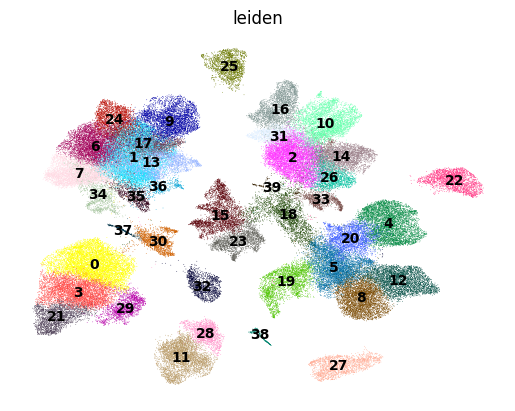

In [27]:
# Visualizing the unlabled Leiden clusters in an UMAP.
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

To check the cell annotation process, please go [here](https://github.com/Fran-bot0/Cell_Annotation_Project).

In [23]:
# Dictionary with annotated cells.
cell_anno = {'0': 'CD4+ T-Cell',
             '1': 'Macrophage',
             '2': 'Fibroblast',
             '3': 'CD8+ T-Cell',
             '4': 'AT1',
             '5': 'AT2',
             '6': 'Macrophage', 
             '7': 'Macrophage',
             '8': 'AT2',
             '9': 'Macrophage',
             '10': 'Fibroblast',
             '11': 'Plasma Cell',
             '12': 'AT2',
             '13': 'Monocyte',
             '14': 'Fibroblast',
             '15': 'Endothelial Cell',
             '16': 'Airway Smooth Muscle Cell',
             '17': 'Macrophage',
             '18': 'AT2',
             '19': 'Clara Cell',
             '20': 'AT1',
             '21': 'NK Cell',
             '22': 'Neural Cell',
             '23': 'Endothelial Cell',
             '24': 'Macrophage',
             '25': 'Endothelial Cell',
             '26': 'Fibroblast',
             '27': 'Epithelial Cell',
             '28': 'Plasma Cell',
             '29': 'Cycling NK/T Cell',
             '30': 'B Cell',
             '31': 'Airway Smooth Muscle Cell',
             '32': 'Mast Cell',
             '33': 'Pericyte',
             '34': 'Dendritic Cell',
             '35': 'Macrophage',
             '36': 'Macrophage',
             '37': 'B Cell',
             '38': 'Erythroid-like Cell',
             '39': 'Airway Epithelia Cell'}

In [28]:
# Saving the cell types in another column of adata.obs.
adata.obs['cell_type'] = adata.obs.leiden.map(cell_anno)

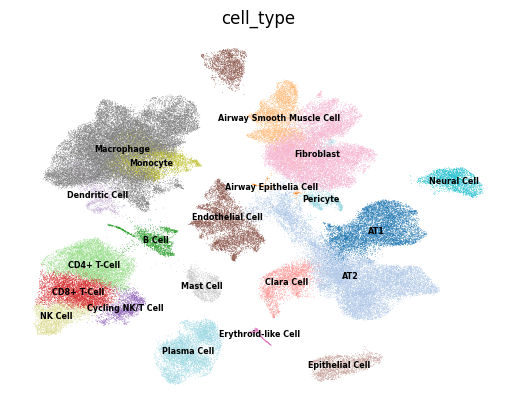

In [29]:
# UMAP of annotated clusters.
sc.pl.umap(adata, color = ['cell_type'], frameon = False, palette='tab20', legend_loc='on data', legend_fontsize='xx-small')

The UMAP visualization reveals expected cell populations, with immune cells (macrophages, monocytes, dendritic cells, T cells, NK cells, B cells) clustering separately from structural lung cells (epithelial, fibroblasts, endothelial). The presence of macrophages and monocytes in a large cluster is expected, as these cells are important for lung immunity, especially during infection. A strong immune cell presence could indicate inflammation.

The presence of cycling NK cells may indicate an active immune response, and expanded mast cell and basophil clusters could suggest excessive inflammation. 
The clear erythroid-like cluster is interesting, as erythroid cells are not typically abundant in lung tissue. The neural cell cluster is unexpected but could stem from alveolar innervation.

If specific cell types are over- or underrepresented, further analysis could reveal infection-driven shifts.

In [30]:
adata.write_h5ad('output_files/analysis_data.h5ad')

# Analysis

In [2]:
adata = sc.read_h5ad('output_files/analysis_data.h5ad')

### Cell Frequencies Across Conditions

In [3]:
def map_condition(sample):
    if 'cov' in sample:
        return 'COV19'
    else:
        return 'Control'

In [4]:
# Create a new column which with the condition of each sample.
adata.obs['condition'] = adata.obs.Sample.map(map_condition)

In [5]:
# Get the total cell number for each sample.
total_cell_num = adata.obs.groupby(['Sample'])[['total_counts']].count()

# Make it a dictionary.
total_cell_num = dict(zip(total_cell_num.index, total_cell_num.total_counts))

In [6]:
# Group the observations by Sample, condition, and cell type, then count the number of occurrences in each group.
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell_type']).count()

# Filter out groups with a total count of zero and reset the index. 
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()

# Gettiingng only the columns of interest.
cell_type_counts = cell_type_counts[cell_type_counts.columns[[0, 1, 2, 5]]]

# Map the total cell count for each Sample using total_cell_num and convert it to an integer
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(total_cell_num).astype(int)

# Calculate the frequency of each cell type within each sample
cell_type_counts['frequency'] = cell_type_counts.total_counts / cell_type_counts.total_cells

# Checking the dataframe.
cell_type_counts.head()

Sample condition                  cell_type  total_counts  total_cells  \
0  C51ctr   Control                        AT1           815         5850   
1  C51ctr   Control                        AT2           775         5850   
2  C51ctr   Control  Airway Smooth Muscle Cell           467         5850   
3  C51ctr   Control                     B Cell            40         5850   
4  C51ctr   Control                CD4+ T-Cell           609         5850   

   frequency  
0   0.139316  
1   0.132479  
2   0.079829  
3   0.006838  
4   0.104103

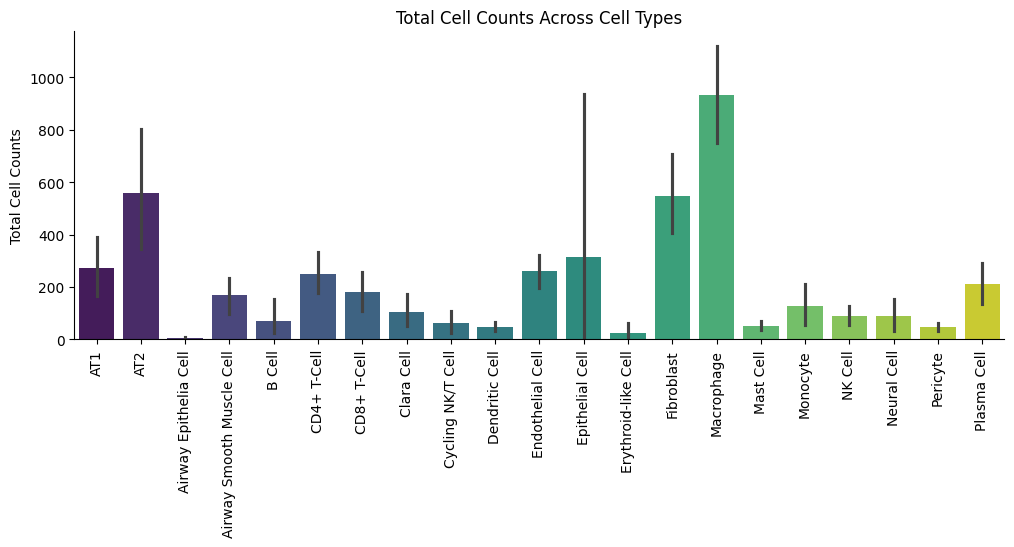

In [7]:
plt.figure(figsize = (12,4))
sns.barplot(data=cell_type_counts, x='cell_type', y='total_counts', palette='viridis')
sns.despine(top=True, right=True)
plt.xlabel('')
plt.ylabel('Total Cell Counts')
plt.title('Total Cell Counts Across Cell Types')
plt.xticks(rotation=90)
plt.show()

Based on the plot no cell types show unexpectedly high counts. All the cell types with the highest counts are expected to be found in lung samples, with some less expected cell populations. This suggests that the sample data is representative of typical lung cell distributions.

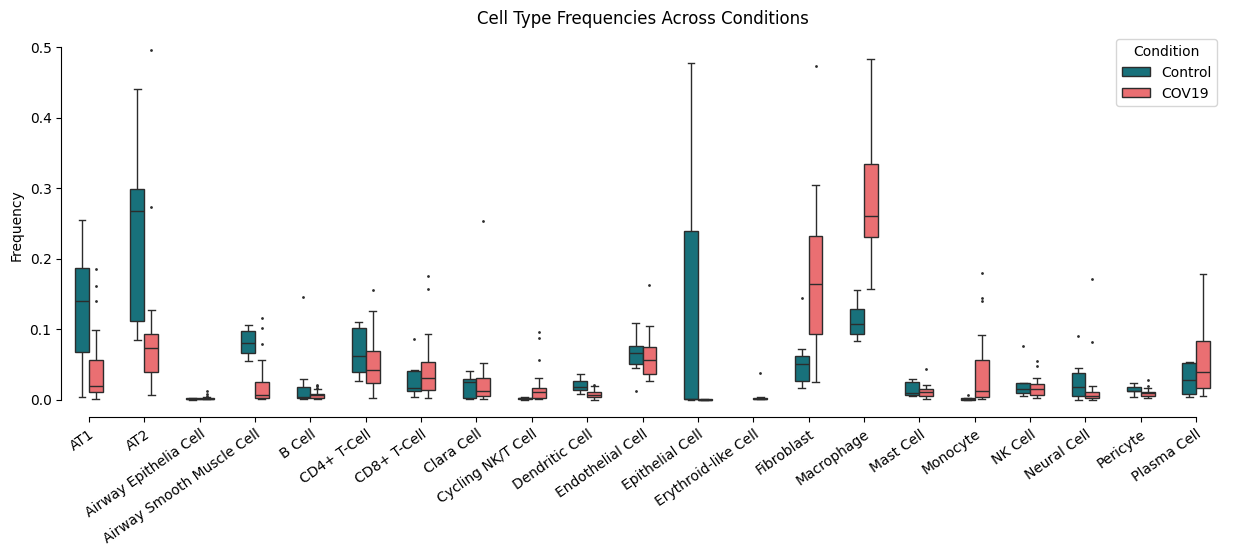

In [8]:
plt.figure(figsize = (15,5))

ax = sns.boxplot(data = cell_type_counts, x = 'cell_type', y = 'frequency', hue = 'condition', 
                 palette={'Control':'#087E8B', 'COV19':'#FF5A5F'}, 
                 width=0.5, fliersize=1)
ax.set(xlabel='', ylabel='Frequency', title='Cell Type Frequencies Across Conditions')
sns.despine(top=True, right=True, trim=True)
plt.legend(title='Condition')
plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')

plt.show()

In this boxplot it can be observed significant shifts in cell type composition between some conditions. A reduction in AT1 and AT2 cells suggests that COVID-19 damages the alveolar epithelium, making lung recovery difficult. On the other hand, an increase in Monocytes/Macrophages suggests persistent inflammation and immune dysregulation. Fibroblasts are involved in wound healing, but their excessive presence suggests the formation of fibrotic tissue.

### Visualization of Marker Genes

In [ ]:
model  = scvi.model.SCVI.load('integration_model', adata)

In [ ]:
cell_type_de = model.differential_expression(groupby = 'cell_type')

DE...:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
adata.uns['cell_type_markers'] = cell_type_de

In [ ]:
adata.write_h5ad('output_files/analysis_data2.h5ad')

In [2]:
adata = sc.read_h5ad('output_files/analysis_data2.h5ad')

In [3]:
cell_type_markers = {}
cats = adata.obs.cell_type.cat.categories

for cell in cats:

    # Getting a dataframe representative of a specific comparison.
    comp = f'{cell} vs Rest'
    comp_df = adata.uns['cell_type_markers'].loc[adata.uns['cell_type_markers'].comparison == comp]

    # Filtering for pvalue < 0.05 and lfc bigger than 0.5.
    comp_df = comp_df[(comp_df['is_de_fdr_0.05']) & (comp_df.lfc_mean > .5)]

    # Keeping only genes where at least 10% of cells express it.
    comp_df = comp_df[comp_df['non_zeros_proportion1'] > 0.1]

    # Save the top 5 genes
    cell_type_markers[cell] = comp_df.index.tolist()[:3]

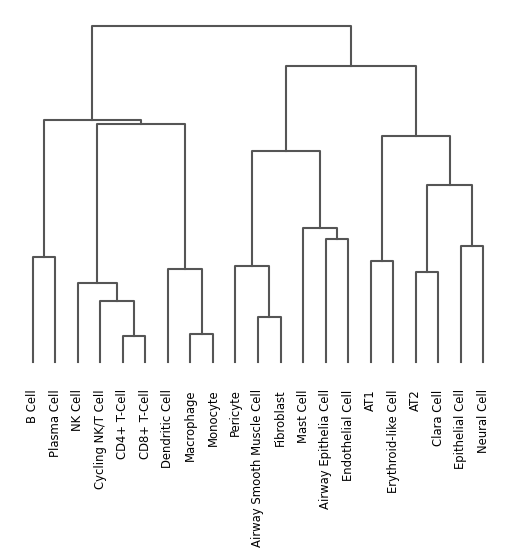

In [4]:
sc.tl.dendrogram(adata, groupby = 'cell_type', use_rep = 'X_scVI')
ax = sc.pl.dendrogram(adata, 'cell_type')

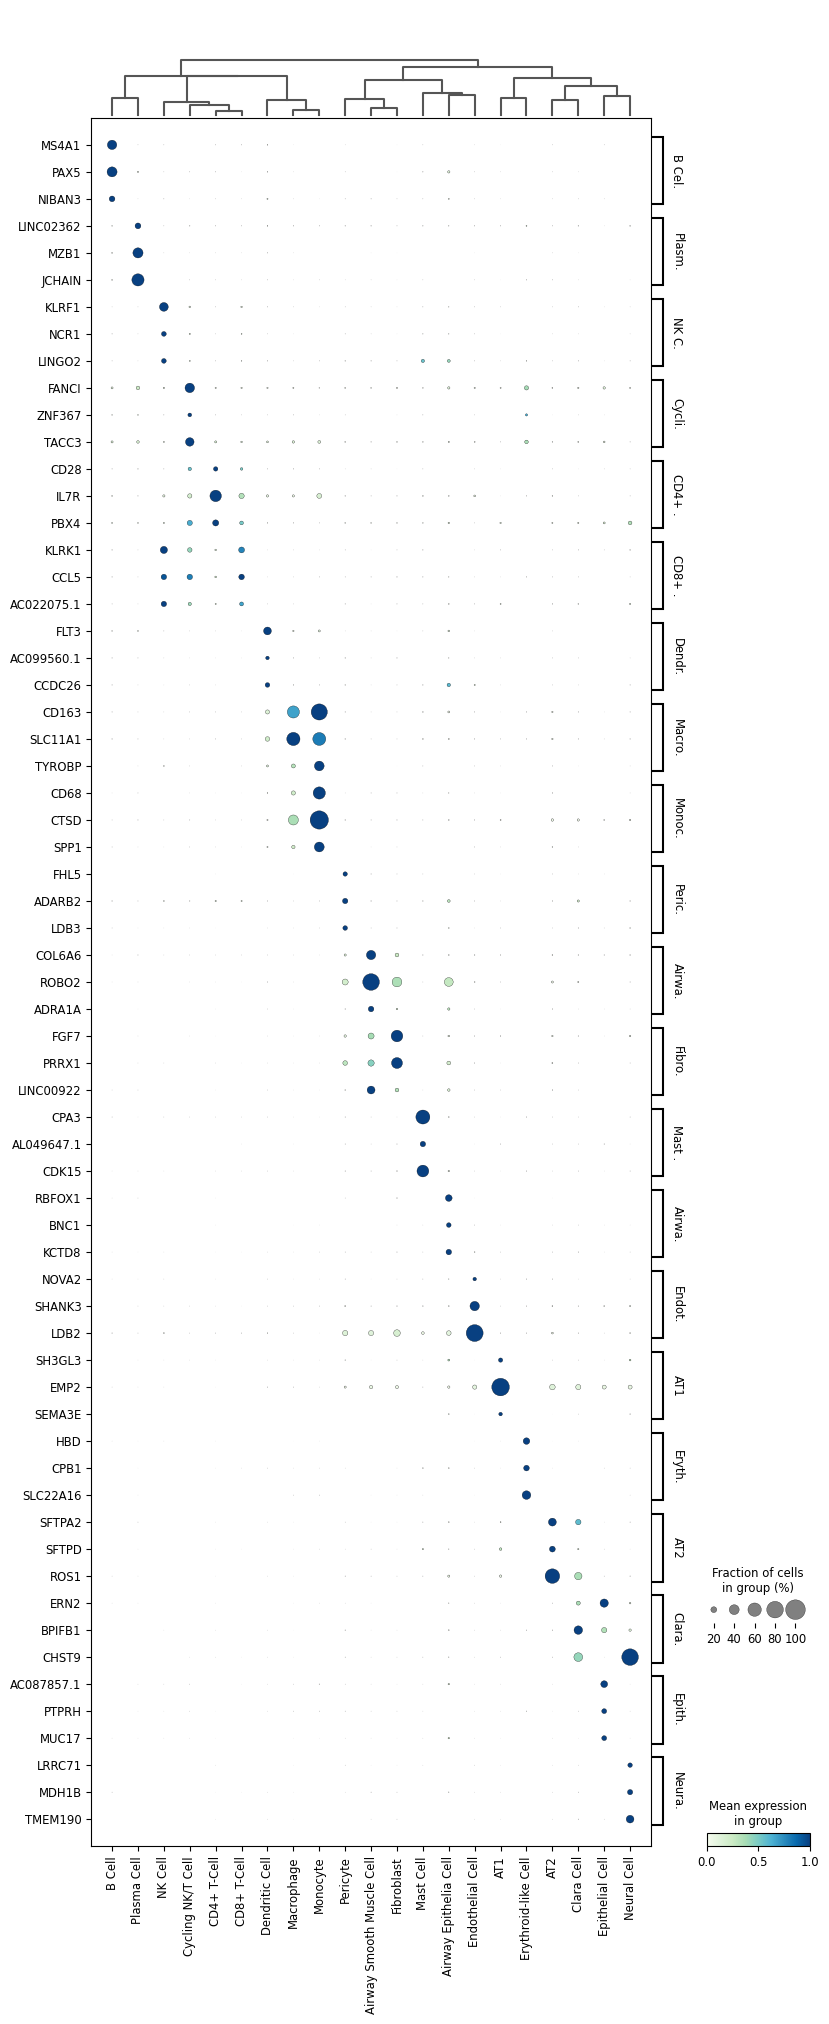

In [48]:
sc.pl.dotplot(
    adata,
    cell_type_markers,
    groupby = ['cell_type'],
    dendrogram = True,
    cmap = 'GnBu',
    swap_axes = True,
    use_raw = True,
    standard_scale = 'var',
)

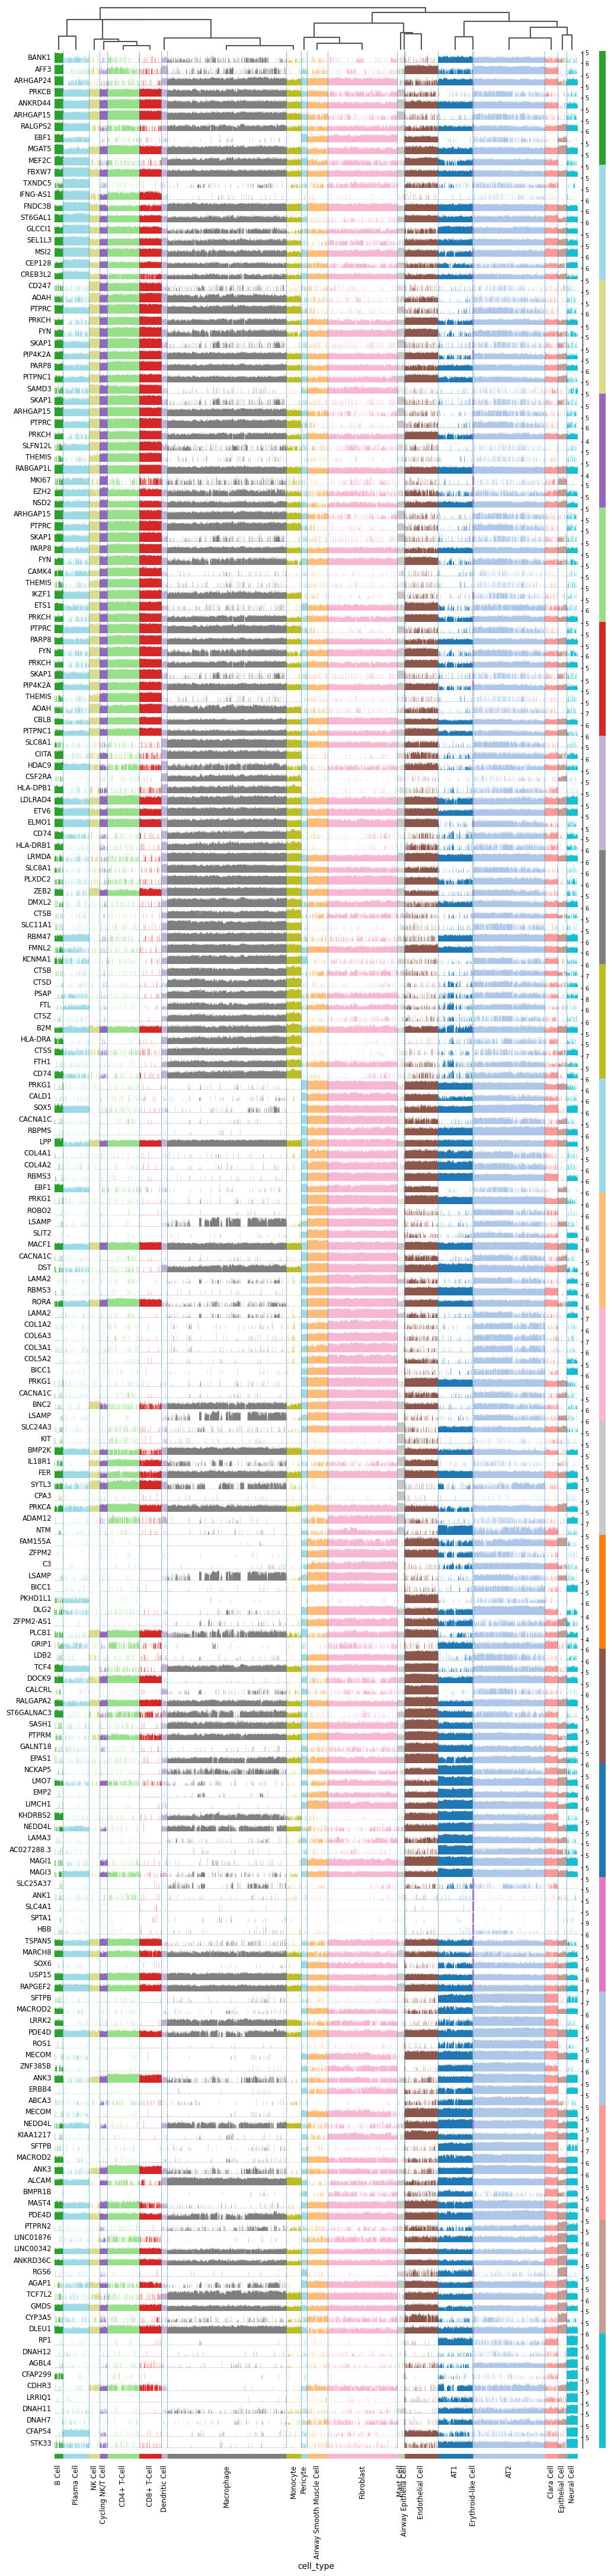

In [6]:
#
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'cell_type', 
    use_raw = True, 
    method = 'wilcoxon', 
    n_genes = 10
)

sc.pl.rank_genes_groups_tracksplot(
    adata, 
    groupby = 'cell_type'
)

### Impact of COVID-19 on AT1 and AT2 Cell Gene Expression

In [10]:
condition_de = model.differential_expression(
    idx1 = (adata.obs['cell_type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'COV19'),
    idx2 = (adata.obs['cell_type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'Control'))

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Keeping only statistally significant expressed genes with a log fold change bigger than 0.5 and smaller than -0.5.
condition_de = condition_de[(condition_de['is_de_fdr_0.05']) & (abs(condition_de.lfc_mean) > .5)].sort_values('lfc_mean')

In [12]:
# Removing genes that are lowly expressed in both AT1 and AT2 cells because, it may not be biologically meaningful even if significant.
condition_de = condition_de[(condition_de.raw_normalized_mean1 > .5) | (condition_de.raw_normalized_mean2 > .5)]

In [13]:
# Looking only at the top 25 upregulated and downregulated genes.
top_genes_condition = condition_de[-25:].index.tolist() + condition_de[:25].index.tolist()

In [14]:
relevant_data_condition = adata[adata.obs['cell_type'].isin(['AT1', 'AT2'])].copy()

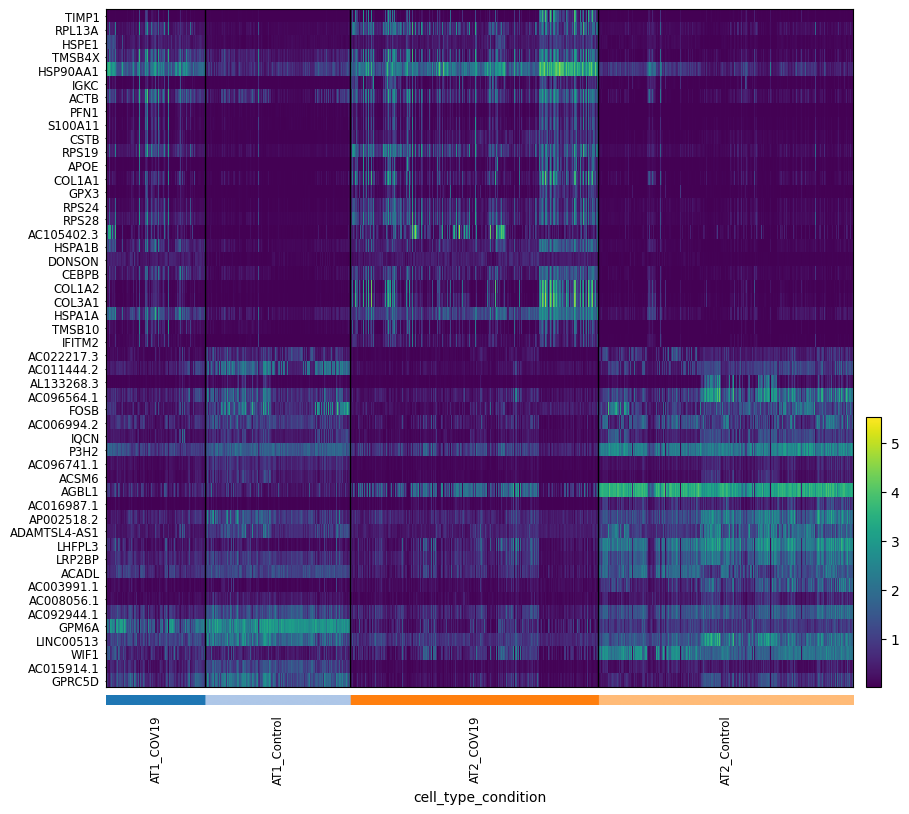

In [15]:
sc.pl.heatmap(relevant_data_condition, top_genes_condition, groupby=['cell_type', 'condition'], swap_axes=True, 
              layer = 'scvi_normalized', log = True)

This heatmap suggests that the expression of genes in both AT1 and AT2 cells is influenced by COVID infection compared to control conditions. The upregulated genes in AT1 COV19 and AT2 COV19 indicate higher expression levels in the infected tissues, which could be related to the immune response or other processes triggered by the infection. AT1 and AT2 cells show distinct expression patterns, with AT2 being more responsive to the infection. The overall trend suggests COVID infection significantly alters gene regulation in these lung cell types.

In [ ]:
adata.write_h5ad('output_files/final_data.h5ad')